In [180]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import warnings 

warnings.filterwarnings('ignore')
df = pd.read_csv('loan_train.csv')
df.info()
df.describe()
df.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Loan_ID              614
Gender               601
Married              611
Dependents           599
Education            614
Self_Employed        582
ApplicantIncome      614
CoapplicantIncome    614
LoanAmount           592
Loan_Amount_Term     600
Credit_History       564
Property_Area        614
Loan_Status          614
dtype: int64

In [181]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [182]:
df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

In [183]:
df['Dependents'].fillna(df['Dependents'].mean(), inplace=True) 

In [184]:
df['Credit_History'].fillna(df['Credit_History'].mean(), inplace=True) 
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

In [185]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [186]:
df = df.dropna()

In [187]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

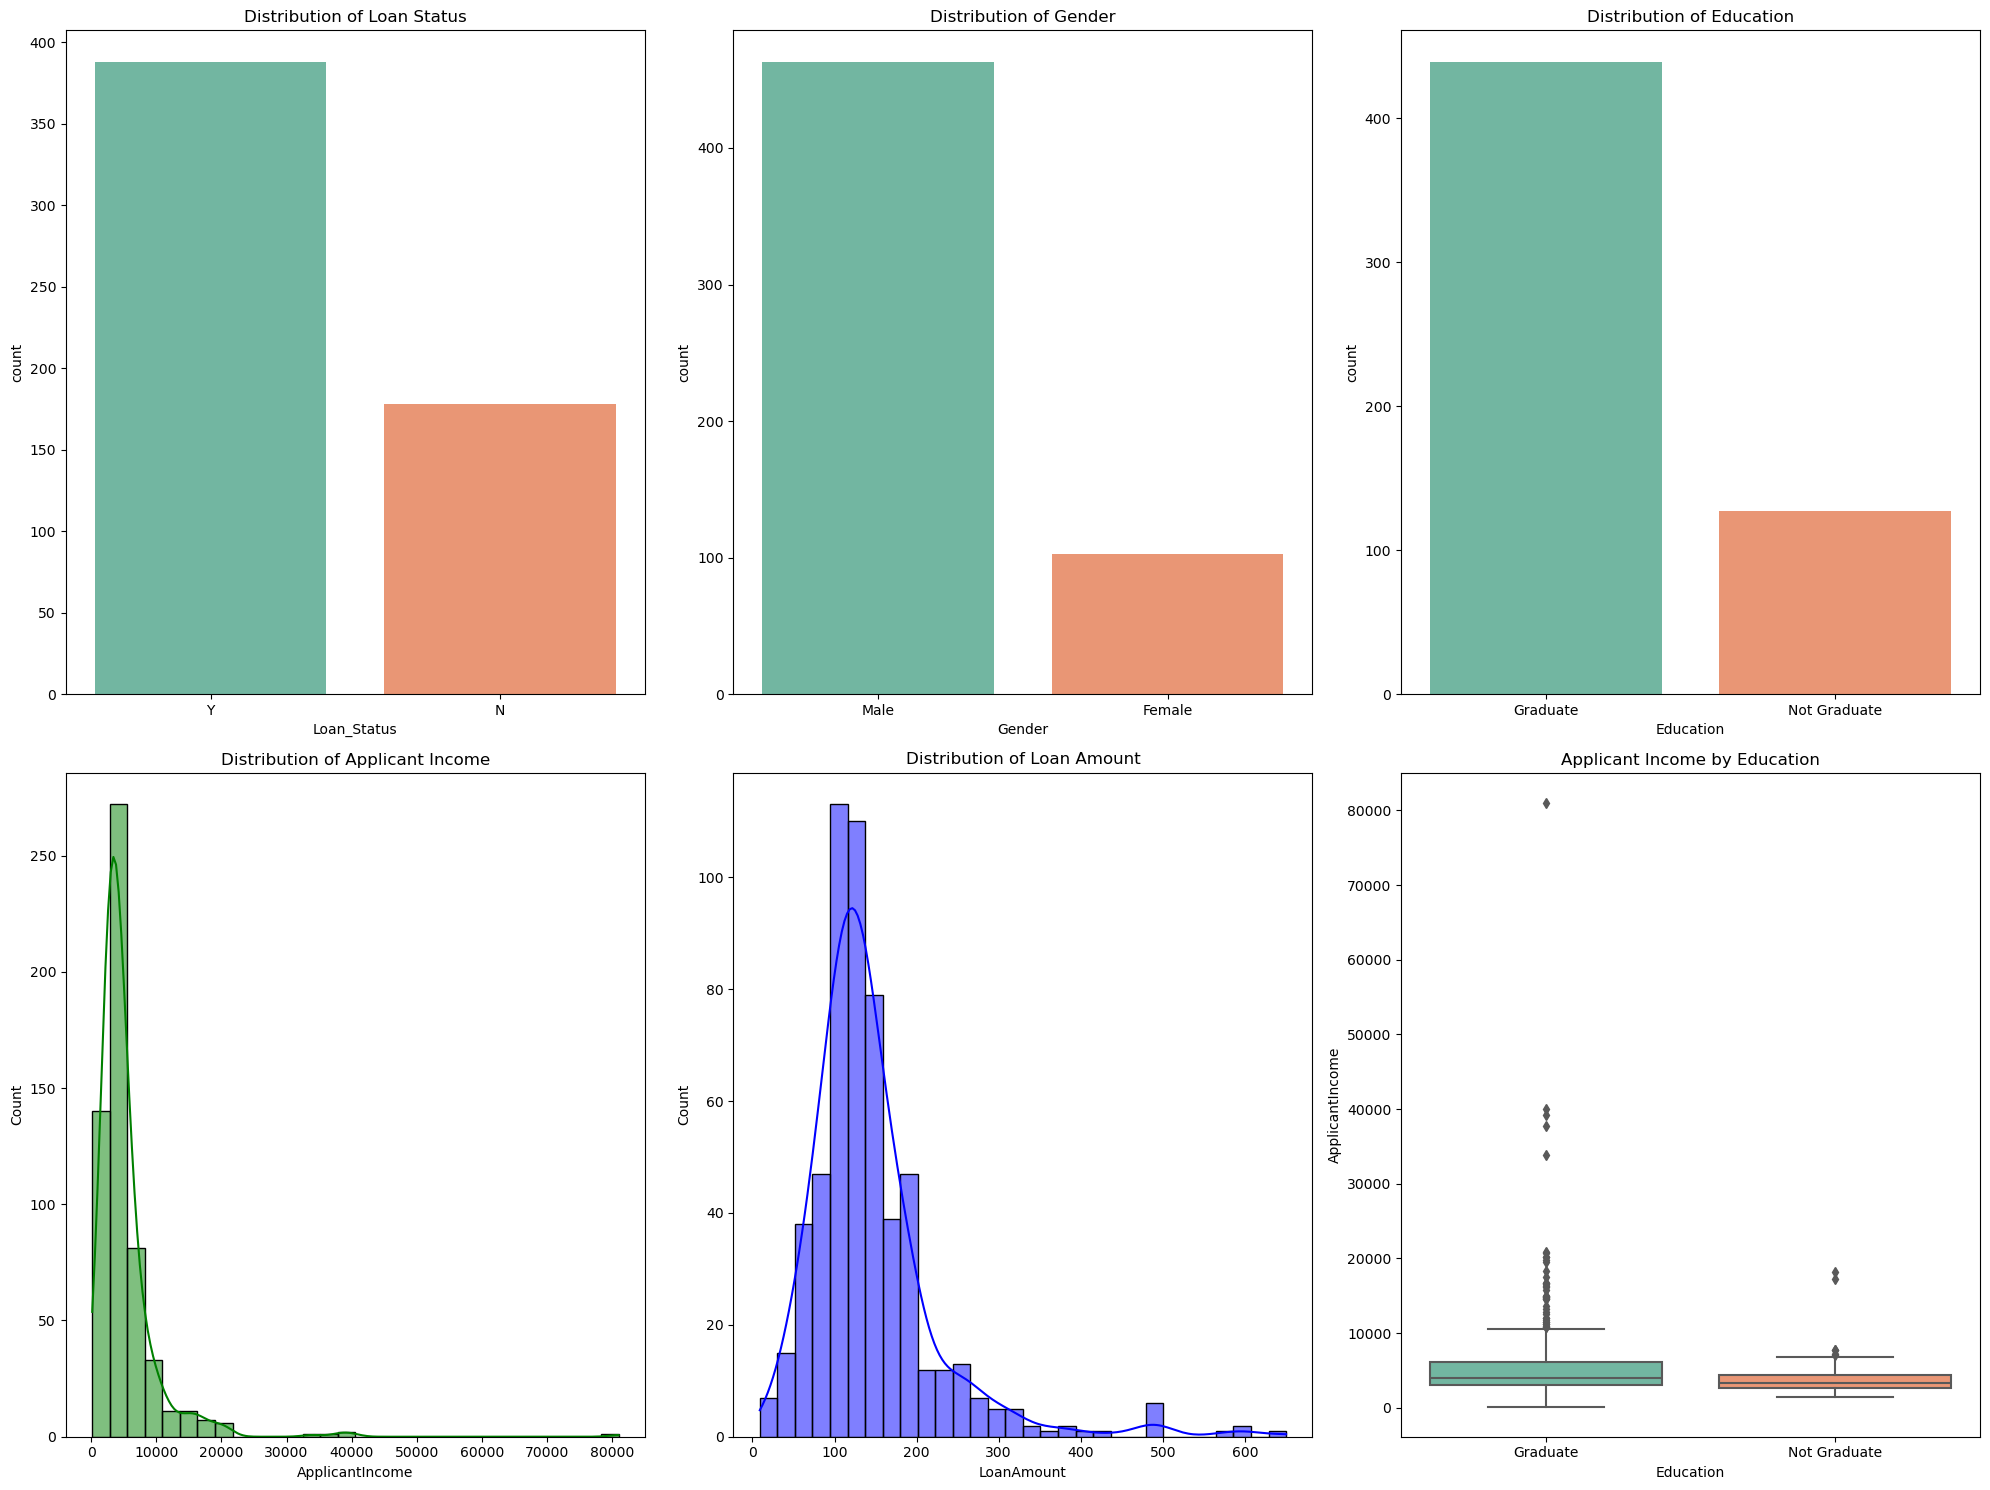

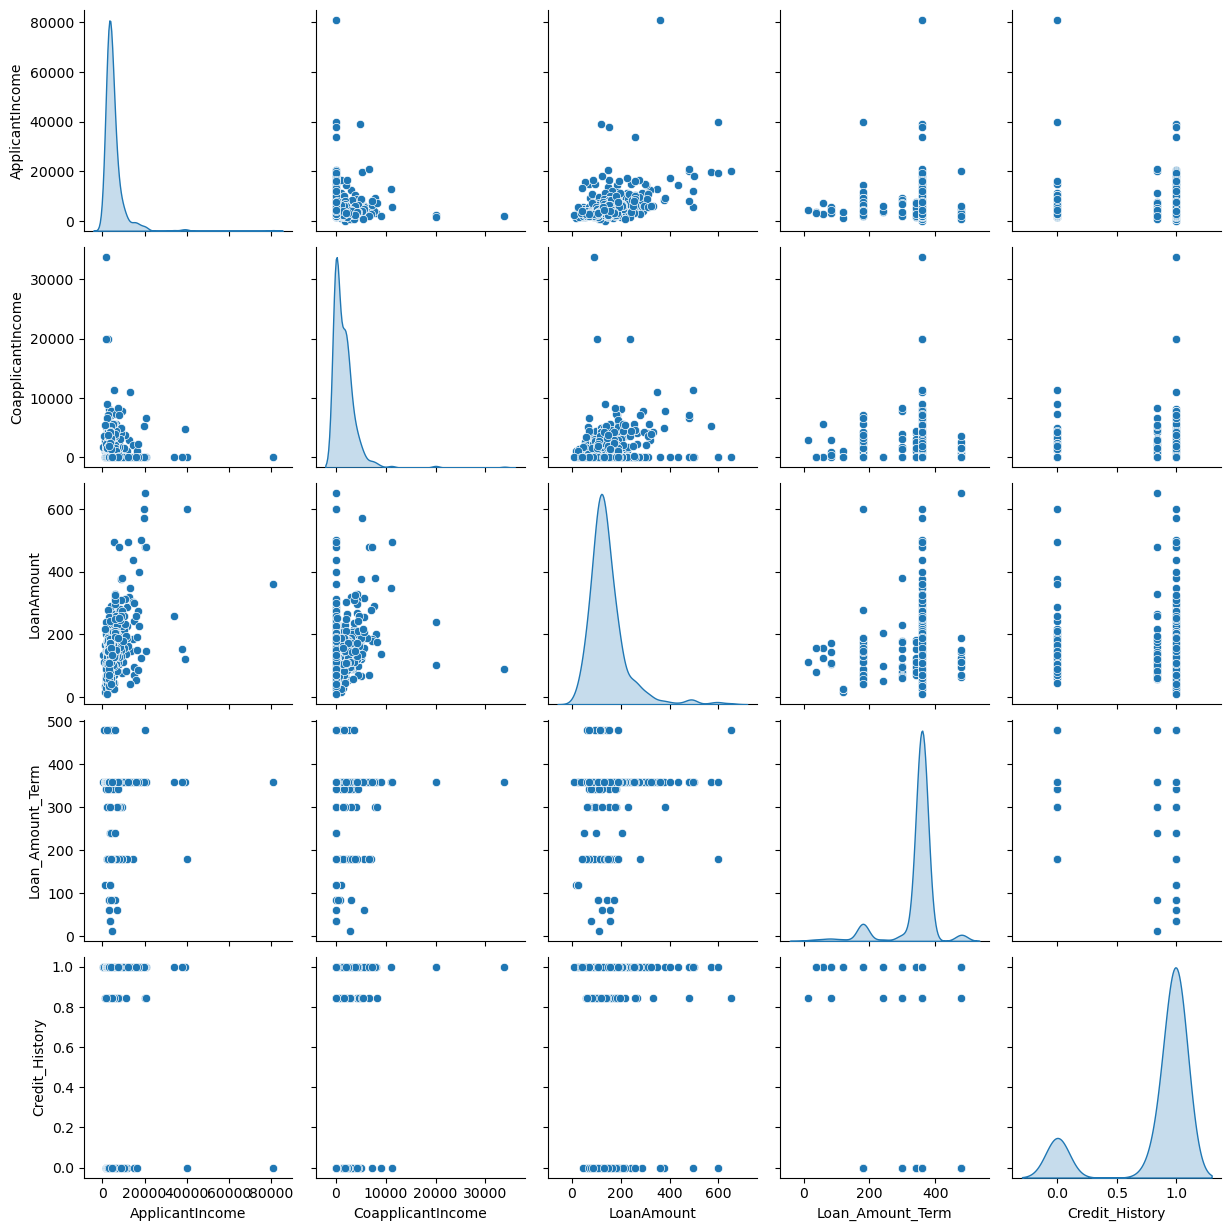

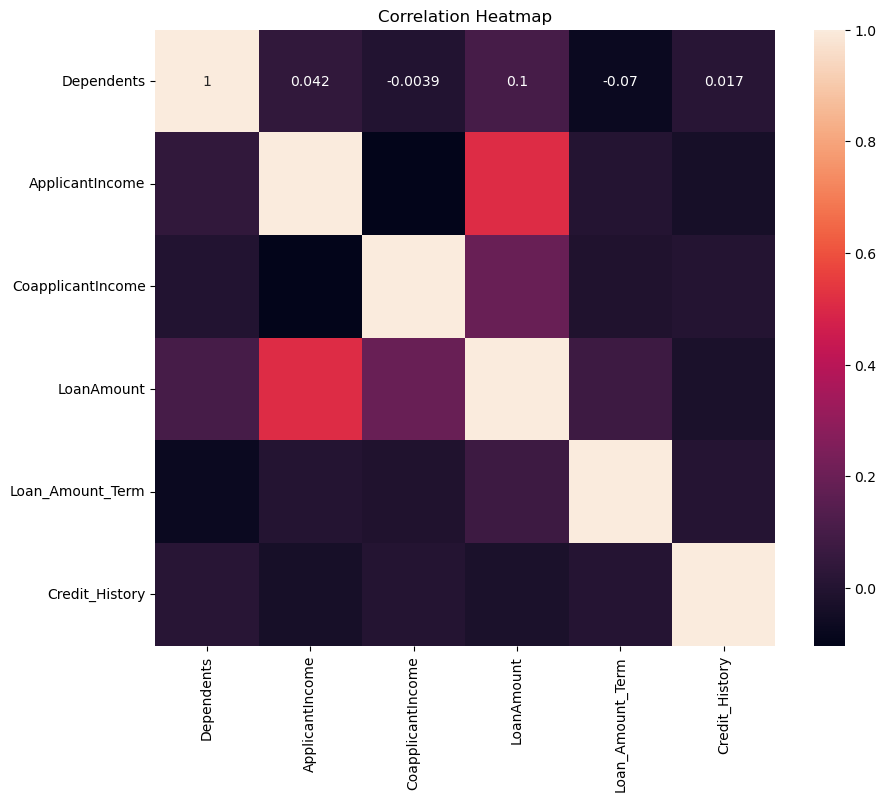

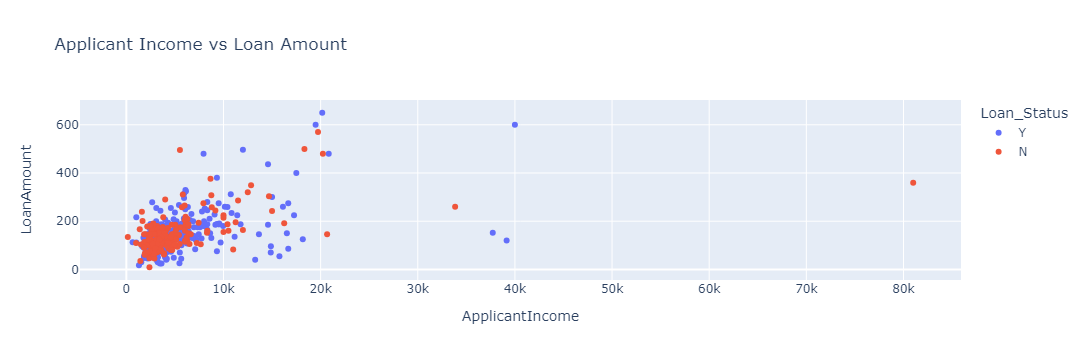

In [189]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# 1. Distribution of Loan Status
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='Loan_Status', palette='Set2')
plt.title('Distribution of Loan Status')

# 2. Distribution of Gender
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Gender', palette='Set2')
plt.title('Distribution of Gender')

# 3. Distribution of Education
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='Education', palette='Set2')
plt.title('Distribution of Education')

# 4. Distribution of Applicant Income
plt.subplot(2, 3, 4)
sns.histplot(data=df, x='ApplicantIncome', kde=True, bins=30, color='green')
plt.title('Distribution of Applicant Income')

# 5. Distribution of Loan Amount
plt.subplot(2, 3, 5)
sns.histplot(data=df, x='LoanAmount', kde=True, bins=30, color='blue')
plt.title('Distribution of Loan Amount')

# 6. Boxplot of Applicant Income by Education
plt.subplot(2, 3, 6)
sns.boxplot(data=df, x='Education', y='ApplicantIncome', palette='Set2')
plt.title('Applicant Income by Education')

plt.tight_layout()
plt.show()

# Pairplot to visualize relationships between variables
sns.pairplot(df[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']], diag_kind='kde')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df[['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

# Plotly scatter plot for Applicant Income vs Loan Amount colored by Loan Status
fig = px.scatter(df, x='ApplicantIncome', y='LoanAmount', color='Loan_Status', title='Applicant Income vs Loan Amount')
fig.show()


In [190]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
df = remove_outliers(df, columns)

In [191]:
# Define the mapping for binary transformation
binary_mappings = {
    'Gender': {'Male': 0, 'Female': 1},
    'Married': {'No': 0, 'Yes': 1},
    'Education': {'Not Graduate': 0, 'Graduate': 1},
    'Self_Employed': {'No': 0, 'Yes': 1},
    'Loan_Status': {'N': 0, 'Y': 1},
}

# Apply the mappings to the dataframe
df.replace(binary_mappings, inplace=True)

# One-hot encode the "Property_Area" column
df = pd.get_dummies(df, columns=['Property_Area'], prefix='Property_Area', drop_first=False)

# Display the transformed dataframe
print("Transformed DataFrame:")
print(df.head())


Transformed DataFrame:
    Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
0  LP001002       0        0         0.0          1              0   
1  LP001003       0        1         1.0          1              0   
2  LP001005       0        1         0.0          1              1   
3  LP001006       0        1         0.0          0              0   
4  LP001008       0        0         0.0          1              0   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0  146.412162             360.0   
1             4583             1508.0  128.000000             360.0   
2             3000                0.0   66.000000             360.0   
3             2583             2358.0  120.000000             360.0   
4             6000                0.0  141.000000             360.0   

   Credit_History  Loan_Status  Property_Area_Rural  Property_Area_Semiurban  \
0             1.0            1                Fal

In [193]:
df = df.drop(["Loan_ID"], axis=1)

In [194]:
X = df.drop(["Loan_Status"], axis=1)
y = df["Loan_Status"]

In [196]:
bool_columns = ['Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']
df[bool_columns] = df[bool_columns].astype('int64')

In [197]:
X, y = SMOTE().fit_resample(X, y)

In [198]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.4f}")
    print("-" * 30)


Logistic Regression:
Accuracy: 0.7565
Precision: 0.6849
Recall: 0.9091
F1 Score: 0.7812
ROC AUC: 0.7629
------------------------------
Decision Tree:
Accuracy: 0.7739
Precision: 0.7636
Recall: 0.7636
F1 Score: 0.7636
ROC AUC: 0.7735
------------------------------
Random Forest:
Accuracy: 0.8348
Precision: 0.7812
Recall: 0.9091
F1 Score: 0.8403
ROC AUC: 0.8379
------------------------------
Gradient Boosting:
Accuracy: 0.7739
Precision: 0.7042
Recall: 0.9091
F1 Score: 0.7937
ROC AUC: 0.7795
------------------------------
SVM:
Accuracy: 0.7478
Precision: 0.6857
Recall: 0.8727
F1 Score: 0.7680
ROC AUC: 0.7530
------------------------------
KNN:
Accuracy: 0.7217
Precision: 0.6769
Recall: 0.8000
F1 Score: 0.7333
ROC AUC: 0.7250
------------------------------
Naive Bayes:
Accuracy: 0.7652
Precision: 0.6795
Recall: 0.9636
F1 Score: 0.7970
ROC AUC: 0.7735
------------------------------


In [275]:
# Define the parameter grid with max_depth ranging from 1 to 50 and None
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None] + list(range(1, 5)) + [10,20,30,40,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform Grid Search
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)


Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best parameters for Random Forest:  {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [210]:
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ", grid_search_lr.best_params_)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters for Logistic Regression:  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}


In [211]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree: ", grid_search_dt.best_params_)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters for Decision Tree:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [212]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train, y_train)
print("Best parameters for Gradient Boosting: ", grid_search_gb.best_params_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters for Gradient Boosting:  {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [213]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search_svm = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)
print("Best parameters for SVM: ", grid_search_svm.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for SVM:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [214]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)
print("Best parameters for KNN: ", grid_search_knn.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for KNN:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [215]:
param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

grid_search_nb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_nb.fit(X_train, y_train)
print("Best parameters for Naive Bayes: ", grid_search_nb.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for Naive Bayes:  {'var_smoothing': 0.002848035868435802}


Random Forest with Best Parameters:
Accuracy: 0.8609
Precision: 0.7910
Recall: 0.9636
F1 Score: 0.8689
ROC AUC: 0.9176
------------------------------


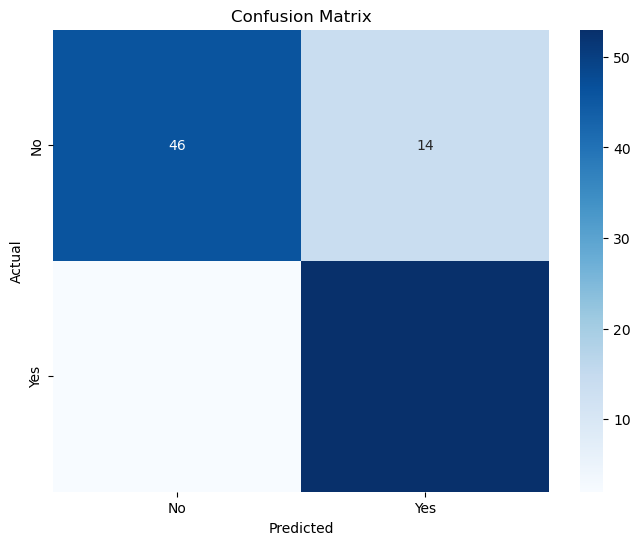

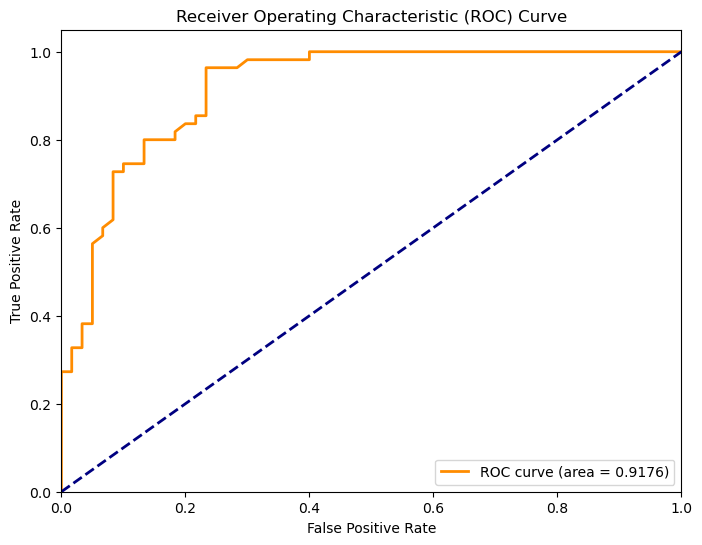

In [274]:
# Define the model with the best parameters
best_params = {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
best_rf_model = RandomForestClassifier(**best_params)

# Train the model
best_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Random Forest with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Logistic Regression with Best Parameters:
Accuracy: 0.7565
Precision: 0.6849
Recall: 0.9091
F1 Score: 0.7812
ROC AUC: 0.8327
------------------------------


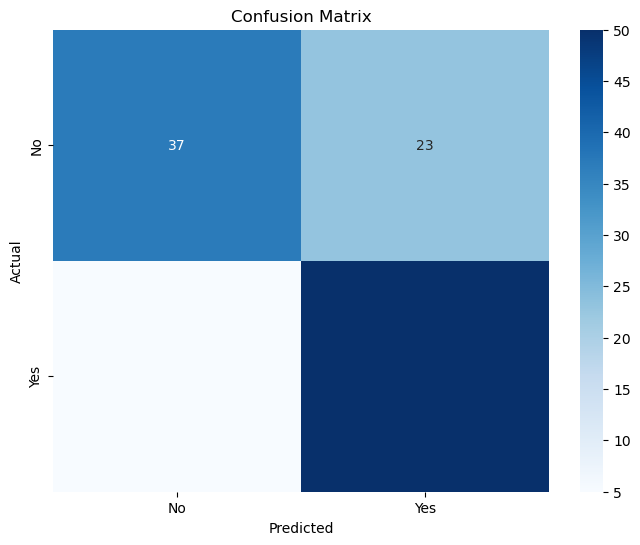

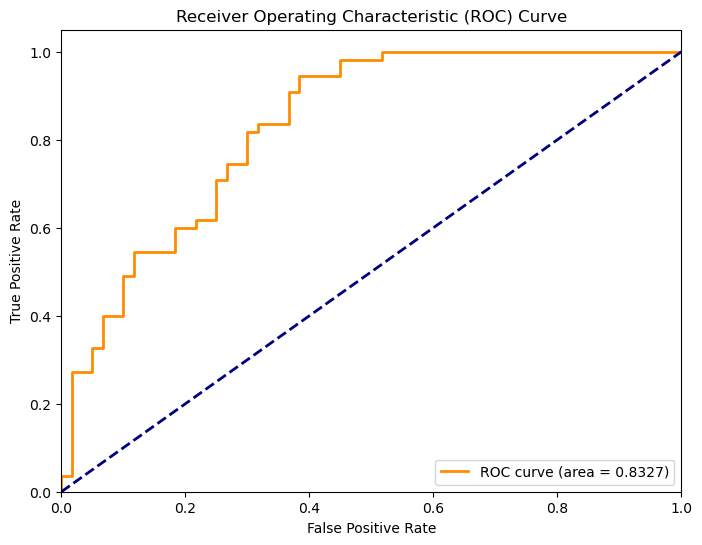

In [262]:
# Define the model with the best parameters
best_params_lr = {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
best_lr_model = LogisticRegression(**best_params_lr)

# Train the model
best_lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_lr_model.predict(X_test)
y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Logistic Regression with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Decision Tree with Best Parameters:
Accuracy: 0.7739
Precision: 0.7544
Recall: 0.7818
F1 Score: 0.7679
ROC AUC: 0.7742
------------------------------


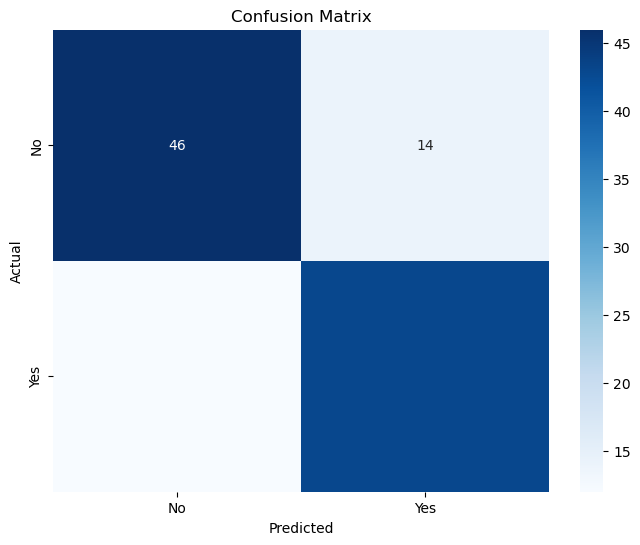

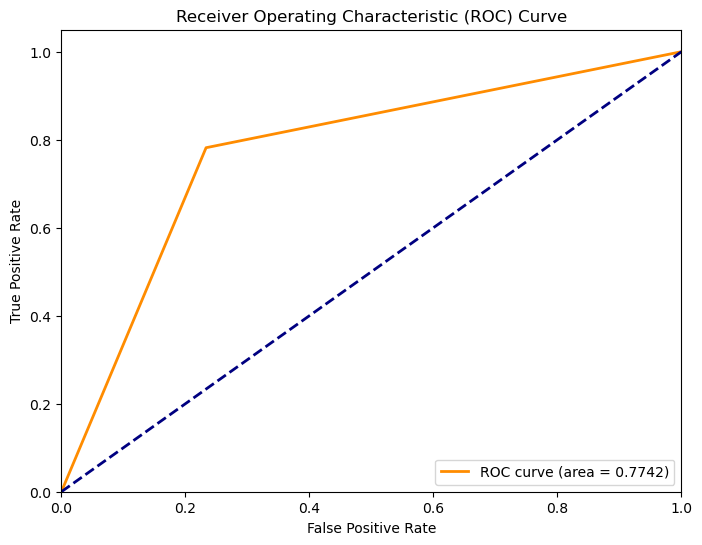

In [219]:
# Define the model with the best parameters
best_params_dt = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_dt_model = DecisionTreeClassifier(**best_params_dt)

# Train the model
best_dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_dt_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Decision Tree with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Gradient Boosting with Best Parameters:
Accuracy: 0.8348
Precision: 0.7727
Recall: 0.9273
F1 Score: 0.8430
ROC AUC: 0.9264
------------------------------


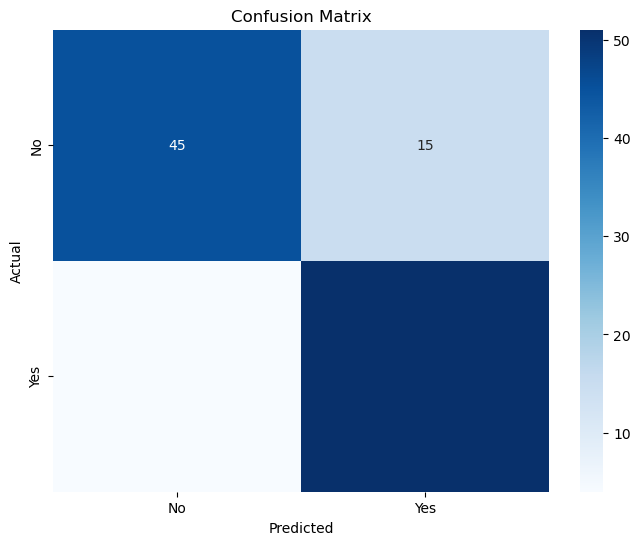

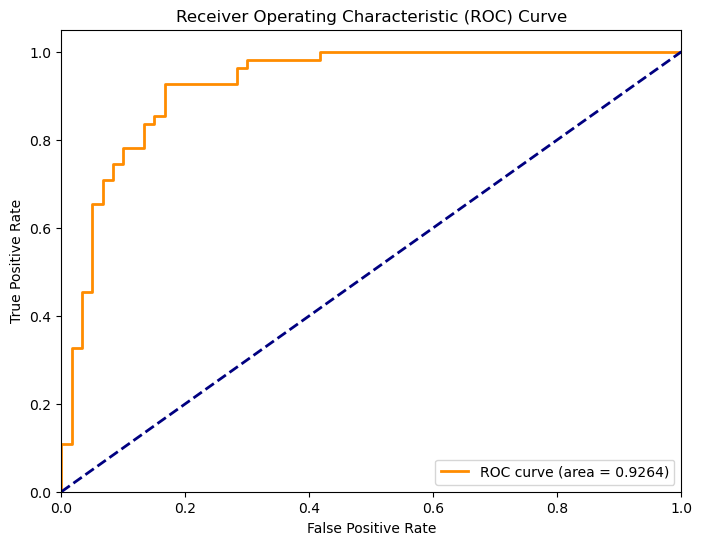

In [220]:
# Define the model with the best parameters
best_params_gb = {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
best_gb_model = GradientBoostingClassifier(**best_params_gb)

# Train the model
best_gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_gb_model.predict(X_test)
y_pred_proba = best_gb_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Gradient Boosting with Best Parameters:")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


SVM with Best Parameters:
Accuracy: 0.8174
Precision: 0.8148
Recall: 0.8000
F1 Score: 0.8073
ROC AUC: 0.9091
------------------------------


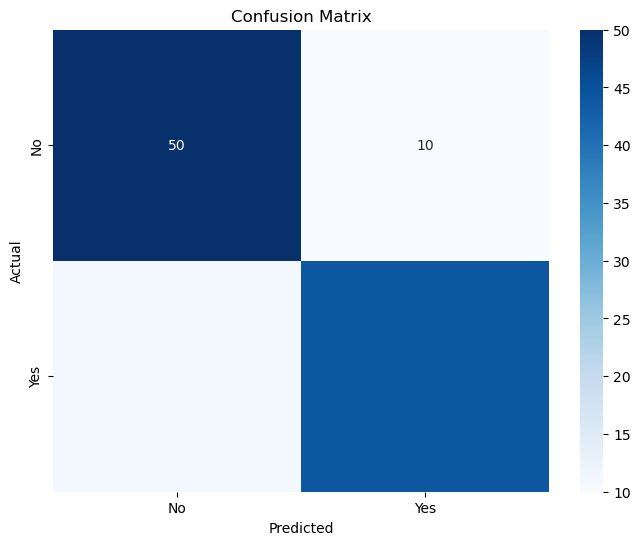

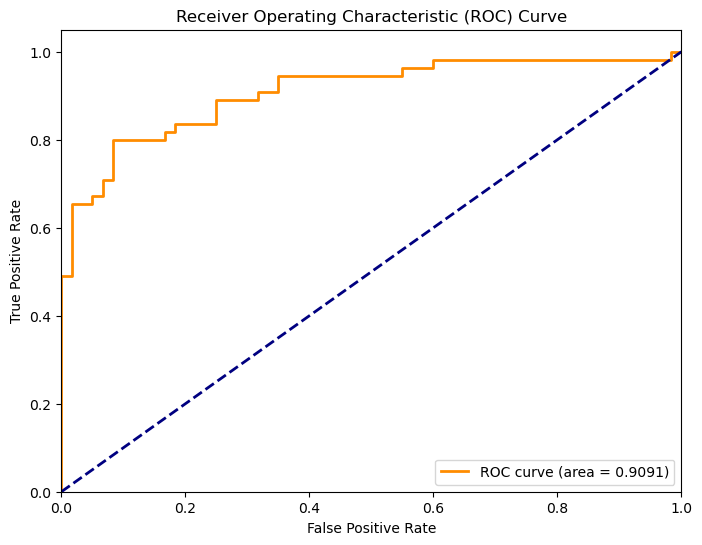

In [222]:
# Define the model with the best parameters
best_params_svm = {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
best_svm_model = SVC(**best_params_svm, probability=True)

# Train the model
best_svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_svm_model.predict(X_test)
y_pred_proba = best_svm_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"SVM with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


K-Nearest Neighbors with Best Parameters:
Accuracy: 0.7826
Precision: 0.7500
Recall: 0.8182
F1 Score: 0.7826
ROC AUC: 0.8912
------------------------------


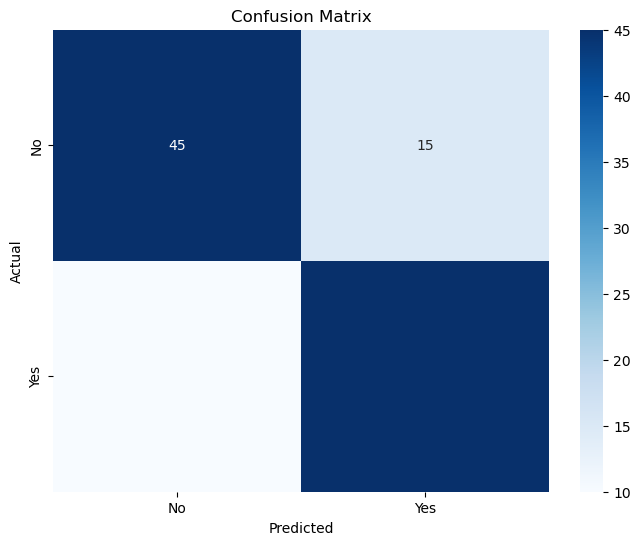

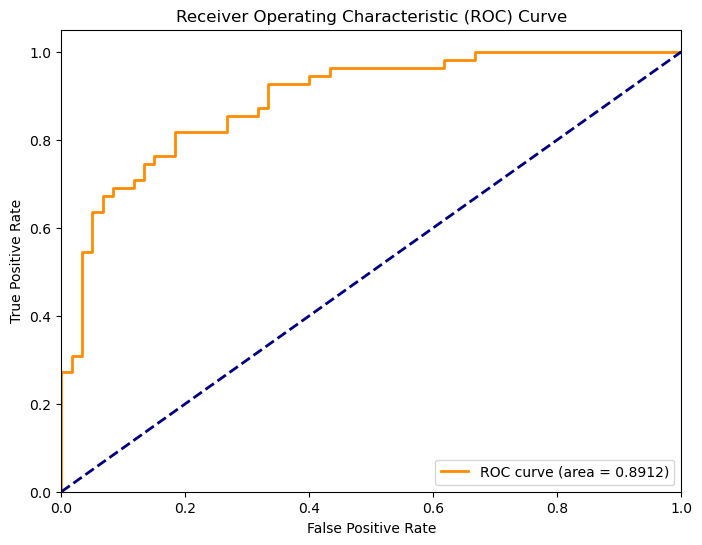

In [223]:
# Define the model with the best parameters
best_params_knn = {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
best_knn_model = KNeighborsClassifier(**best_params_knn)

# Train the model
best_knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_knn_model.predict(X_test)
y_pred_proba = best_knn_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"K-Nearest Neighbors with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Naive Bayes with Best Parameters:
Accuracy: 0.7652
Precision: 0.6795
Recall: 0.9636
F1 Score: 0.7970
ROC AUC: 0.8091
------------------------------


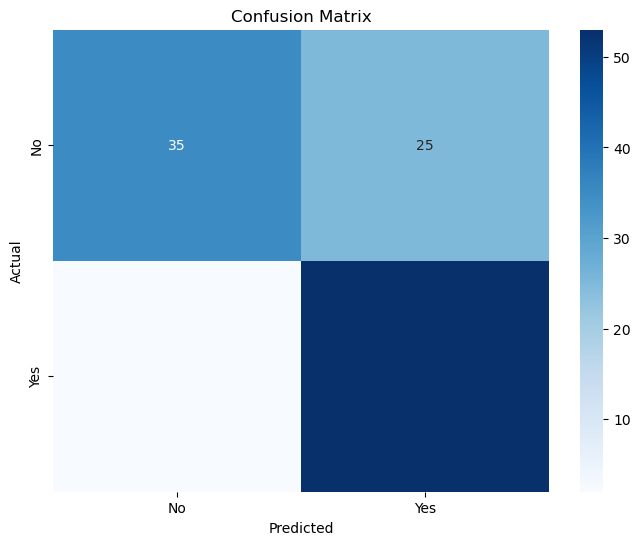

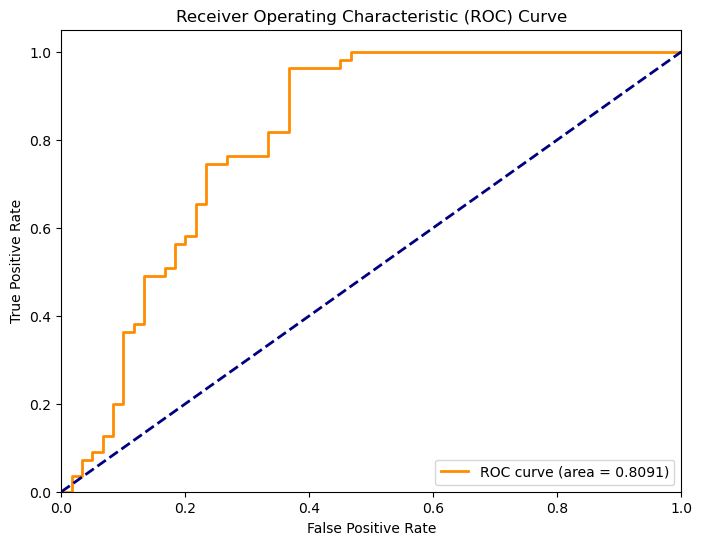

In [224]:
# Define the model with the best parameters
best_params_nb = {'var_smoothing': 0.002848035868435802}
best_nb_model = GaussianNB(**best_params_nb)

# Train the model
best_nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_nb_model.predict(X_test)
y_pred_proba = best_nb_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Naive Bayes with Best Parameters:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("-" * 30)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [277]:
import joblib

# Save the best Logistic Regression model
joblib.dump(grid_search_lr.best_estimator_, 'best_lr_model.pkl')

# Save the best Decision Tree model
joblib.dump(grid_search_dt.best_estimator_, 'best_dt_model.pkl')

# Save the best Random Forest model
joblib.dump(grid_search_rf.best_estimator_, 'best_rf_model.pkl')

# Save the best Gradient Boosting model
joblib.dump(grid_search_gb.best_estimator_, 'best_gb_model.pkl')

# Save the best SVM model
joblib.dump(grid_search_svm.best_estimator_, 'best_svm_model.pkl')

# Save the best KNN model
joblib.dump(grid_search_knn.best_estimator_, 'best_knn_model.pkl')

# Save the best Naive Bayes model
joblib.dump(grid_search_nb.best_estimator_, 'best_nb_model.pkl')


['best_nb_model.pkl']